# Zillow Prize Challenge

### Import some libraries

In [1]:
import pandas as pd
import numpy as np
import pdb
import seaborn
import math
import seaborn as sns 
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn import preprocessing
import datetime as dt
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
warnings.filterwarnings('ignore')


### Read the data from properties, training and submission file(used for training and prediction)

In [2]:
df = pd.read_csv('/Users/kiranmayi/Desktop/Sem1/DSF_519/Hw2/properties_2016.csv', low_memory=False )
trainingData = pd.read_csv('/Users/kiranmayi/Desktop/Sem1/DSF_519/Hw2/train_2016_v2.csv', low_memory=False )
submission_data = pd.read_csv('/Users/kiranmayi/Desktop/Sem1/DSF_519/Hw2/sample_submission.csv', low_memory=False )

### Calculate Pearson Correlation between some interesting features

In [3]:
ignoreFeatures = [ 'parcelid', 'propertyzoningdesc', 'propertycountylandusecode','taxdelinquencyflag', 'hashottuborspa', 'fireplaceflag', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'decktypeid', 'pool\
cnt', 'poolsizesum', 'storytypeid', 'assessmentyear','buildingclasstypeid' ]
interestingFeatures = ['yearbuilt','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'bedroomcnt', 'taxamount', 'bathroomcnt', 'propertylandusetypeid', 'calculatedfinishedsquarefeet', 'unitcnt']
features = df.keys()
numFeatures = len(features)
correlation = []
requiredFeatures = list(set(features)-set(ignoreFeatures))
for key1 in interestingFeatures:
    featureCorel = []
    for key2 in interestingFeatures:
        dataFrame = pd.DataFrame( { key1: df[key1], key2: df[key2] } )
        dataFrame = dataFrame.dropna()
        corel = np.corrcoef(dataFrame[key1],dataFrame[key2])[0, 1]
        #print( "corelation between " + key1 + " and " +  key2 + " is " + str( corel ) )
        featureCorel.append(corel)
    if len(featureCorel) != 0:
        correlation.append(featureCorel)

### Plot the heat map for the Pearson correlation 

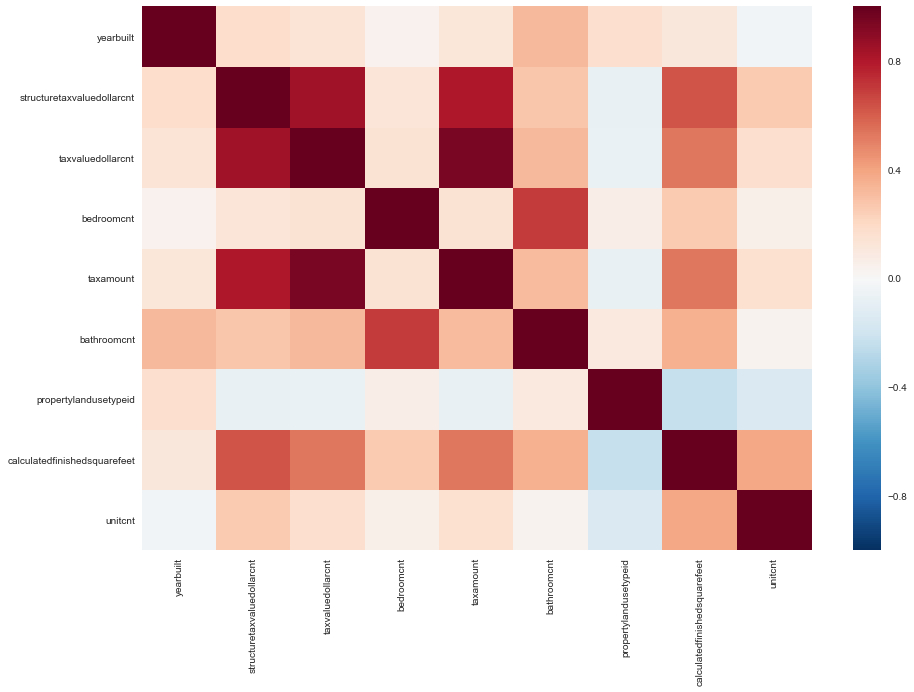

In [4]:
sns.set()
data = pd.DataFrame( correlation, index=interestingFeatures, columns=interestingFeatures )
sns.plt.figure(figsize = (15,10))
ax = sns.heatmap( data )
sns.plt.show()

#### Line graph comparing landtaxvaluedollarcnt, taxvaluedollarcnt and structuretaxvaluedollarcnt with taxamount
We can see that all 3 vary almost similarly with taxamount. Shows that all 3 can be linearly dependent.

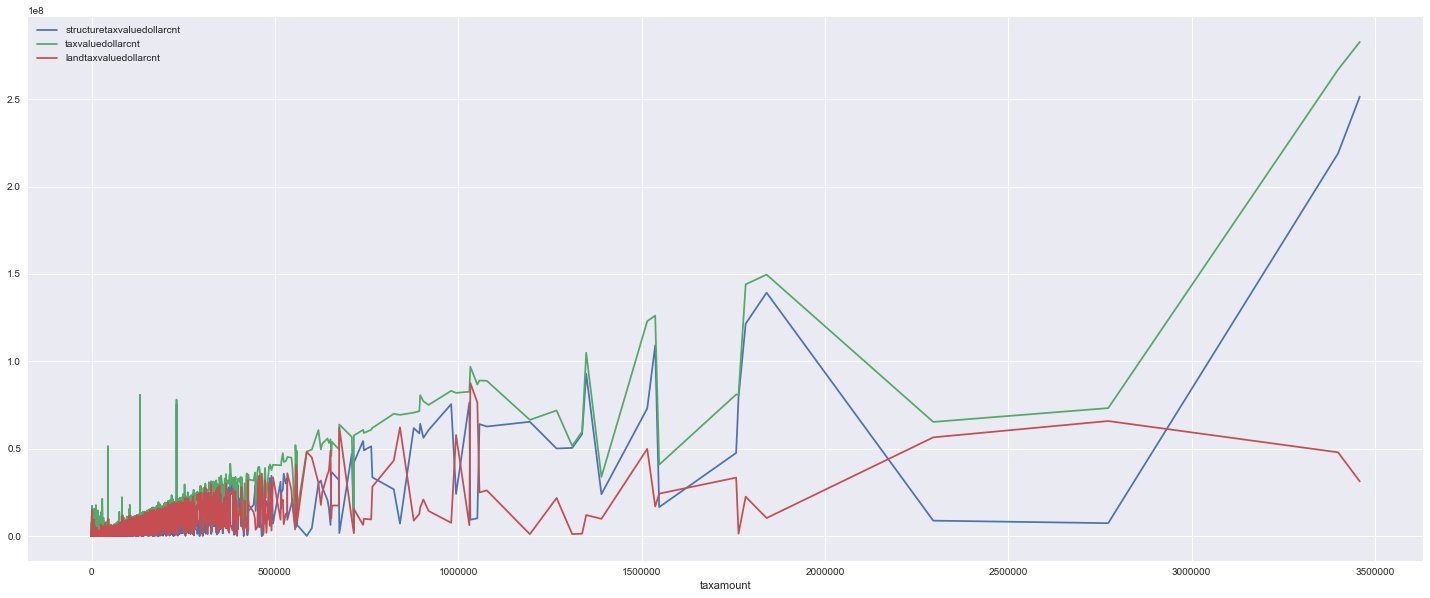

In [5]:
interestingFeatures2 = [ 'taxamount' ]
interestingFeatures3 = ['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']
for f1 in interestingFeatures2:
    plt.figure(figsize=(25,10),facecolor='white')
    for f2 in interestingFeatures3:
        if f1 != f2:
            dataFrame = pd.DataFrame( { f1: df[f1], f2: df[f2] } )
            dataFrame = dataFrame.dropna(how='any')
            dataFrame = dataFrame.sort_values([f1])
            #print(dataFrame.head(10))
            plt.plot(dataFrame[f1],dataFrame[f2], label=f2)
            plt.xlabel(f1)
            #plt.ylabel(f2)
    if f1 !=f2:
        plt.legend(loc='best')
        plt.show()

### Get the Prediction data
Here we do a inner join between the submission data and properties file and get all the properties for the parcelid's we have to predict the logerror for.
We need this data for months october, november and december, 2016 and 2017.
The transaction date for each parcelid is choosen randomly based on the month we predict.
This transaction date is also used as a feature while building the model. Therefore choosing the date randomly makes it easier when we normalize the data.

In [6]:
submission_data.rename(columns={'ParcelId': 'parcelid'}, inplace=True)
prediction_data = df.merge(submission_data, how='inner', on='parcelid')

prediction_data.drop(['201610', '201611','201612','201710','201711','201712'], axis=1, inplace=True)

ignoreFeaturesForPredictionData = [ 'propertyzoningdesc', 'propertycountylandusecode','taxdelinquencyflag', 'hashottuborspa', 'fireplaceflag', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'decktypeid', 'pool\
cnt', 'poolsizesum', 'storytypeid' ]

for ignore_feature in ignoreFeaturesForPredictionData:
    prediction_data.drop(ignore_feature, axis=1, inplace=True)
    
for feature in prediction_data.keys():
    if feature == 'parcelid':
        continue
    mean = prediction_data[feature].mean()
    prediction_data[feature].fillna(mean.real, inplace=True)
    #print(test_data[feature].count())
    
    
def fillRandomTransactionDate(frame,days,year,month):
    frame['transactiondate'] = np.random.randint(1,days, size=len(frame['transactiondate']))
    frame['transactiondate'] = frame['transactiondate'].astype(int).astype('str')
    frame['transactiondate'] = year+'-'+month+'-'+frame['transactiondate']
    frame['transactiondate'] = pd.to_datetime(frame['transactiondate'])
    frame['transactiondate'] = frame['transactiondate'].map(dt.datetime.toordinal)
    return frame['transactiondate']
    
prediction_data_october16 = deepcopy(prediction_data)
prediction_data_october16['transactiondate'] = 0
prediction_data_october16['transactiondate'] = fillRandomTransactionDate(prediction_data_october16,31,'2016','10')

prediction_data_november16 = deepcopy(prediction_data)
prediction_data_november16['transactiondate'] = 0
prediction_data_november16['transactiondate'] = fillRandomTransactionDate(prediction_data_november16,30,'2016','11')

prediction_data_december16 = deepcopy(prediction_data)
prediction_data_december16['transactiondate'] = 0
prediction_data_december16['transactiondate'] = fillRandomTransactionDate(prediction_data_december16,31,'2016','12')

prediction_data_october17 = deepcopy(prediction_data)
prediction_data_october17['transactiondate'] = 0
prediction_data_october17['transactiondate'] = fillRandomTransactionDate(prediction_data_october17,31,'2017','10')

prediction_data_november17 = deepcopy(prediction_data)
prediction_data_november17['transactiondate'] = 0
prediction_data_november17['transactiondate'] = fillRandomTransactionDate(prediction_data_november17,30,'2017','10')

prediction_data_december17 = deepcopy(prediction_data)
prediction_data_december17['transactiondate'] = 0
prediction_data_december17['transactiondate'] = fillRandomTransactionDate(prediction_data_december17,31,'2017','12')

parcelid = pd.DataFrame( { 'parcelid':prediction_data_october16['parcelid'] } )

prediction_data_october16.drop(['parcelid'],axis=1,inplace=True)
prediction_data_november16.drop(['parcelid'],axis=1,inplace=True)
prediction_data_december16.drop(['parcelid'],axis=1,inplace=True)
prediction_data_october17.drop(['parcelid'],axis=1,inplace=True)
prediction_data_november17.drop(['parcelid'],axis=1,inplace=True)
prediction_data_december17.drop(['parcelid'],axis=1,inplace=True)

### Get the training and testing data prepared
Here we do a inner join between properties file and training data to get the details about all the properties for the training data.
For the missing values for some properties, the cells are filled with mean of that particular column.
For simplicity columns with non-numeric values are ignored for now.

In [5]:
joined_data = pd.merge(df, trainingData, on='parcelid', how='inner')

for ignore_feature in ignoreFeatures:
    joined_data.drop(ignore_feature, axis=1, inplace=True)
    
joined_data['transactiondate'] = pd.to_datetime(joined_data['transactiondate'])    
joined_data['transactiondate']=joined_data['transactiondate'].map(dt.datetime.toordinal)
data_with_mean = deepcopy(joined_data)
joined_data_copy = deepcopy(joined_data)

target = pd.DataFrame( {'logerror': data_with_mean['logerror'] })

data_with_mean.drop(['logerror'], axis=1, inplace=True)

for feature in data_with_mean.keys():
    mean = data_with_mean[feature].mean()
    data_with_mean[feature].fillna(mean.real, inplace=True)
    
for feature in joined_data_copy.keys():
    mean = joined_data_copy[feature].mean()
    joined_data_copy[feature].fillna(mean.real, inplace=True)
    
data_with_mean_copy = deepcopy(data_with_mean)

### Some Informative Plots

#### Distribution of logerror

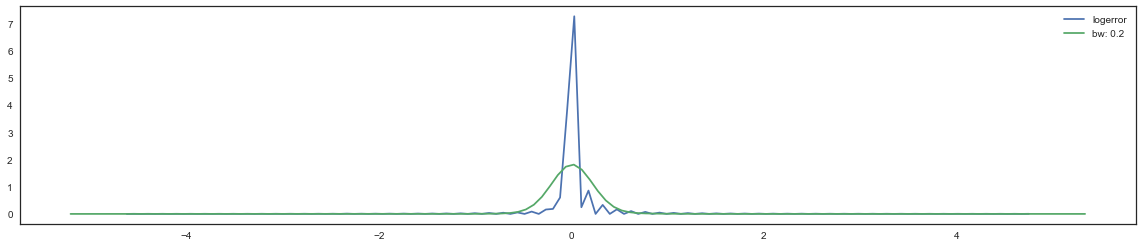

In [10]:
with sns.axes_style("white"):
    sns.plt.figure(figsize = (20,4))
    sns.kdeplot(joined_data['logerror'])
    sns.kdeplot(joined_data['logerror'], bw=.2, label="bw: 0.2")
    plt.legend();
    plt.show()

#### Correlation between logerror and couple of features

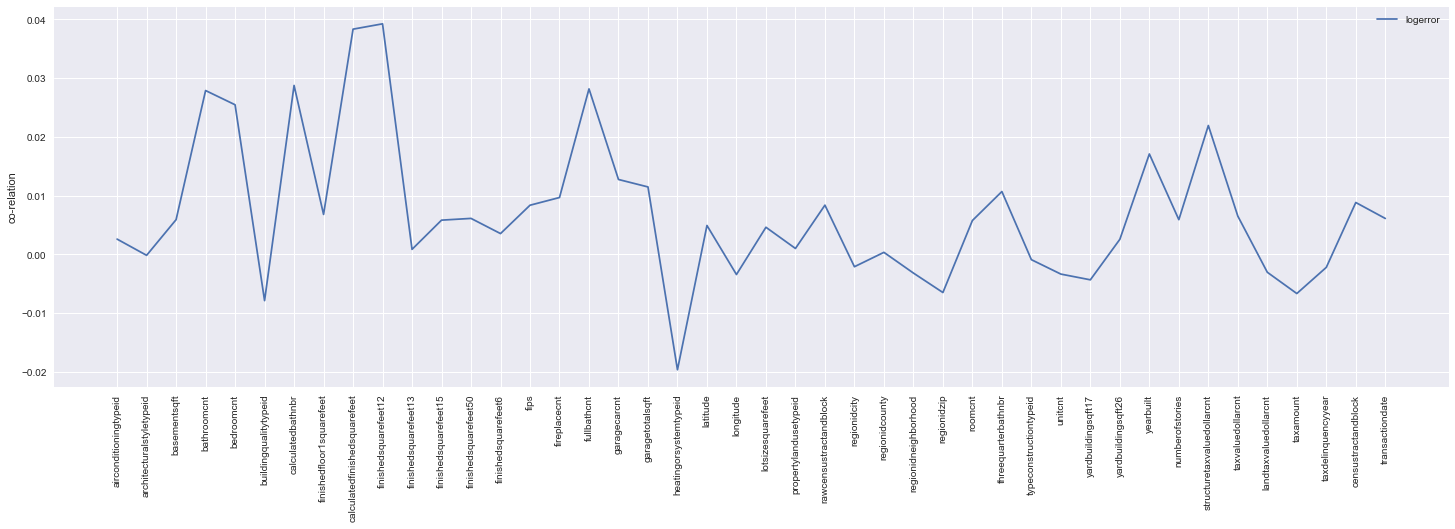

In [25]:
features = joined_data_copy.keys()
data = dict()
i=0
for key2 in features:
    if key2 == 'logerror':
        continue
    dataFrame = pd.DataFrame( { 'logerror': joined_data_copy['logerror'], key2: joined_data_copy[key2] } )
    corel = np.corrcoef(dataFrame['logerror'],dataFrame[key2])[0, 1]
    data[key2] = corel
    i = i+1

x = list(range(0,44))

plt.figure(figsize=(25,7),facecolor='white')
plt.plot(x,list(data.values()),label='logerror')
plt.xticks(x, list(data.keys()),rotation='vertical')
plt.ylabel('co-relation')
plt.legend();
plt.show()


#### Showing distribution of number of houses built in various years.

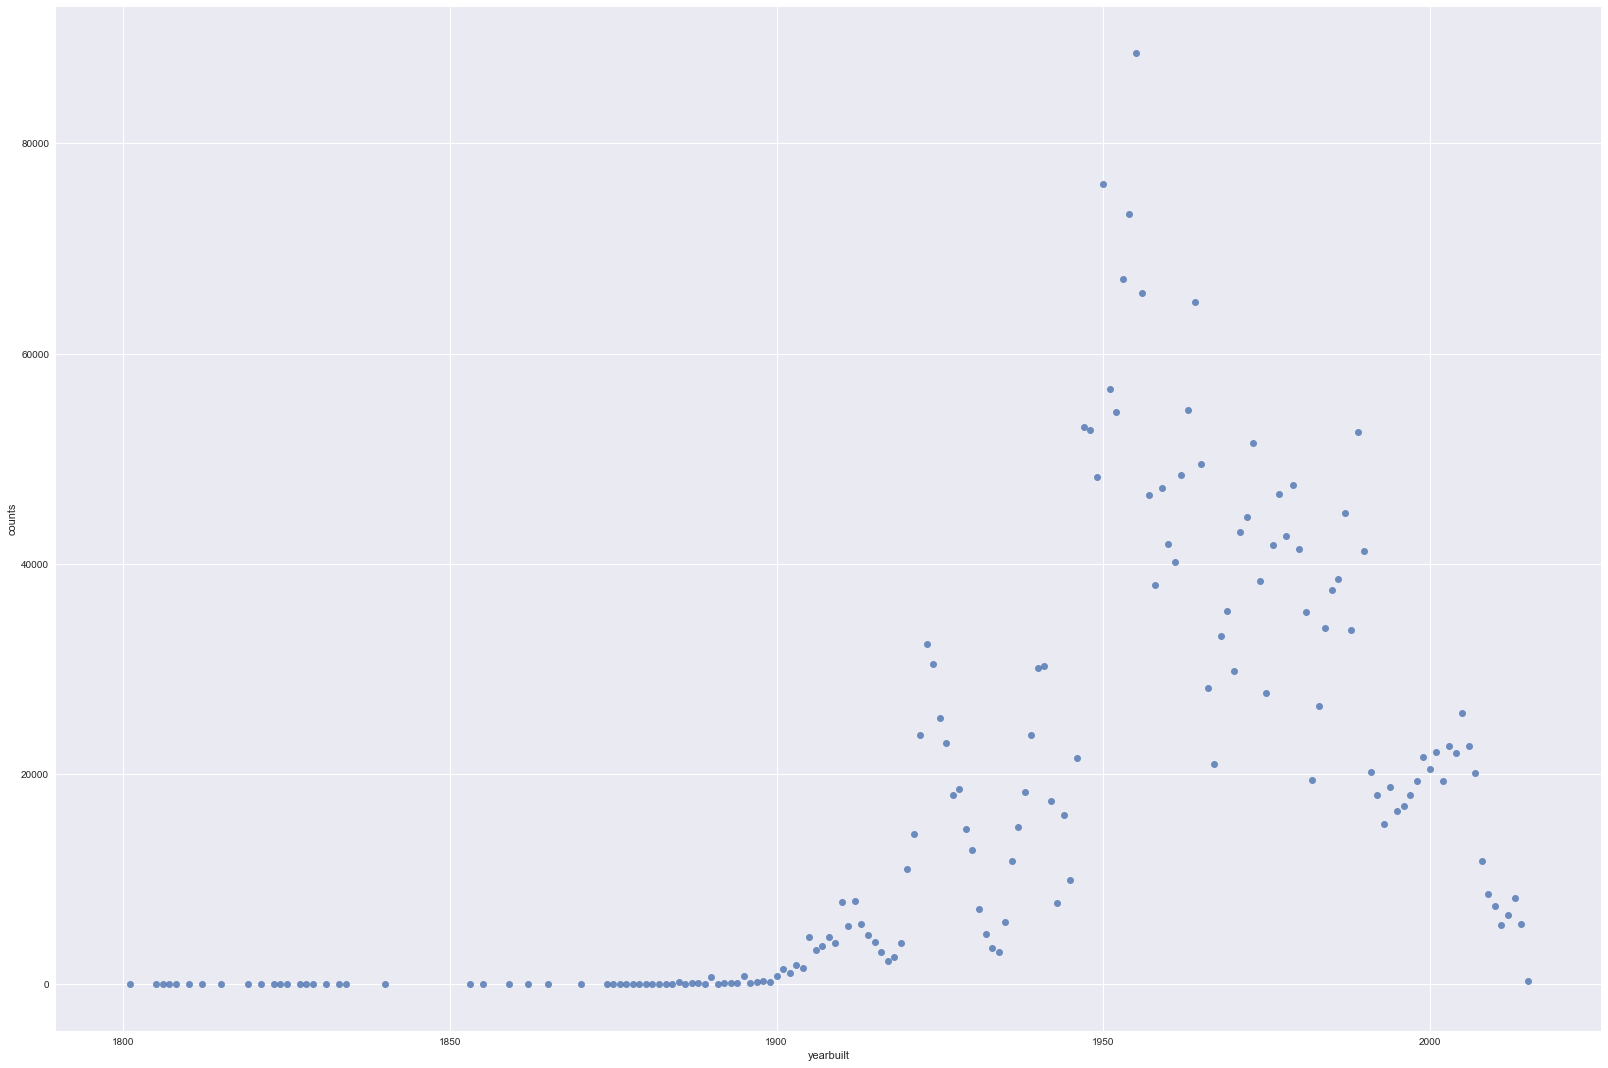

In [6]:
x = df.groupby(['yearbuilt']).size().reset_index(name='counts')
sns.lmplot("yearbuilt", "counts", data=x, size=15,aspect=1.5, fit_reg=False)

#### Scatter plot showing which regions/zipcode have how many number of houses

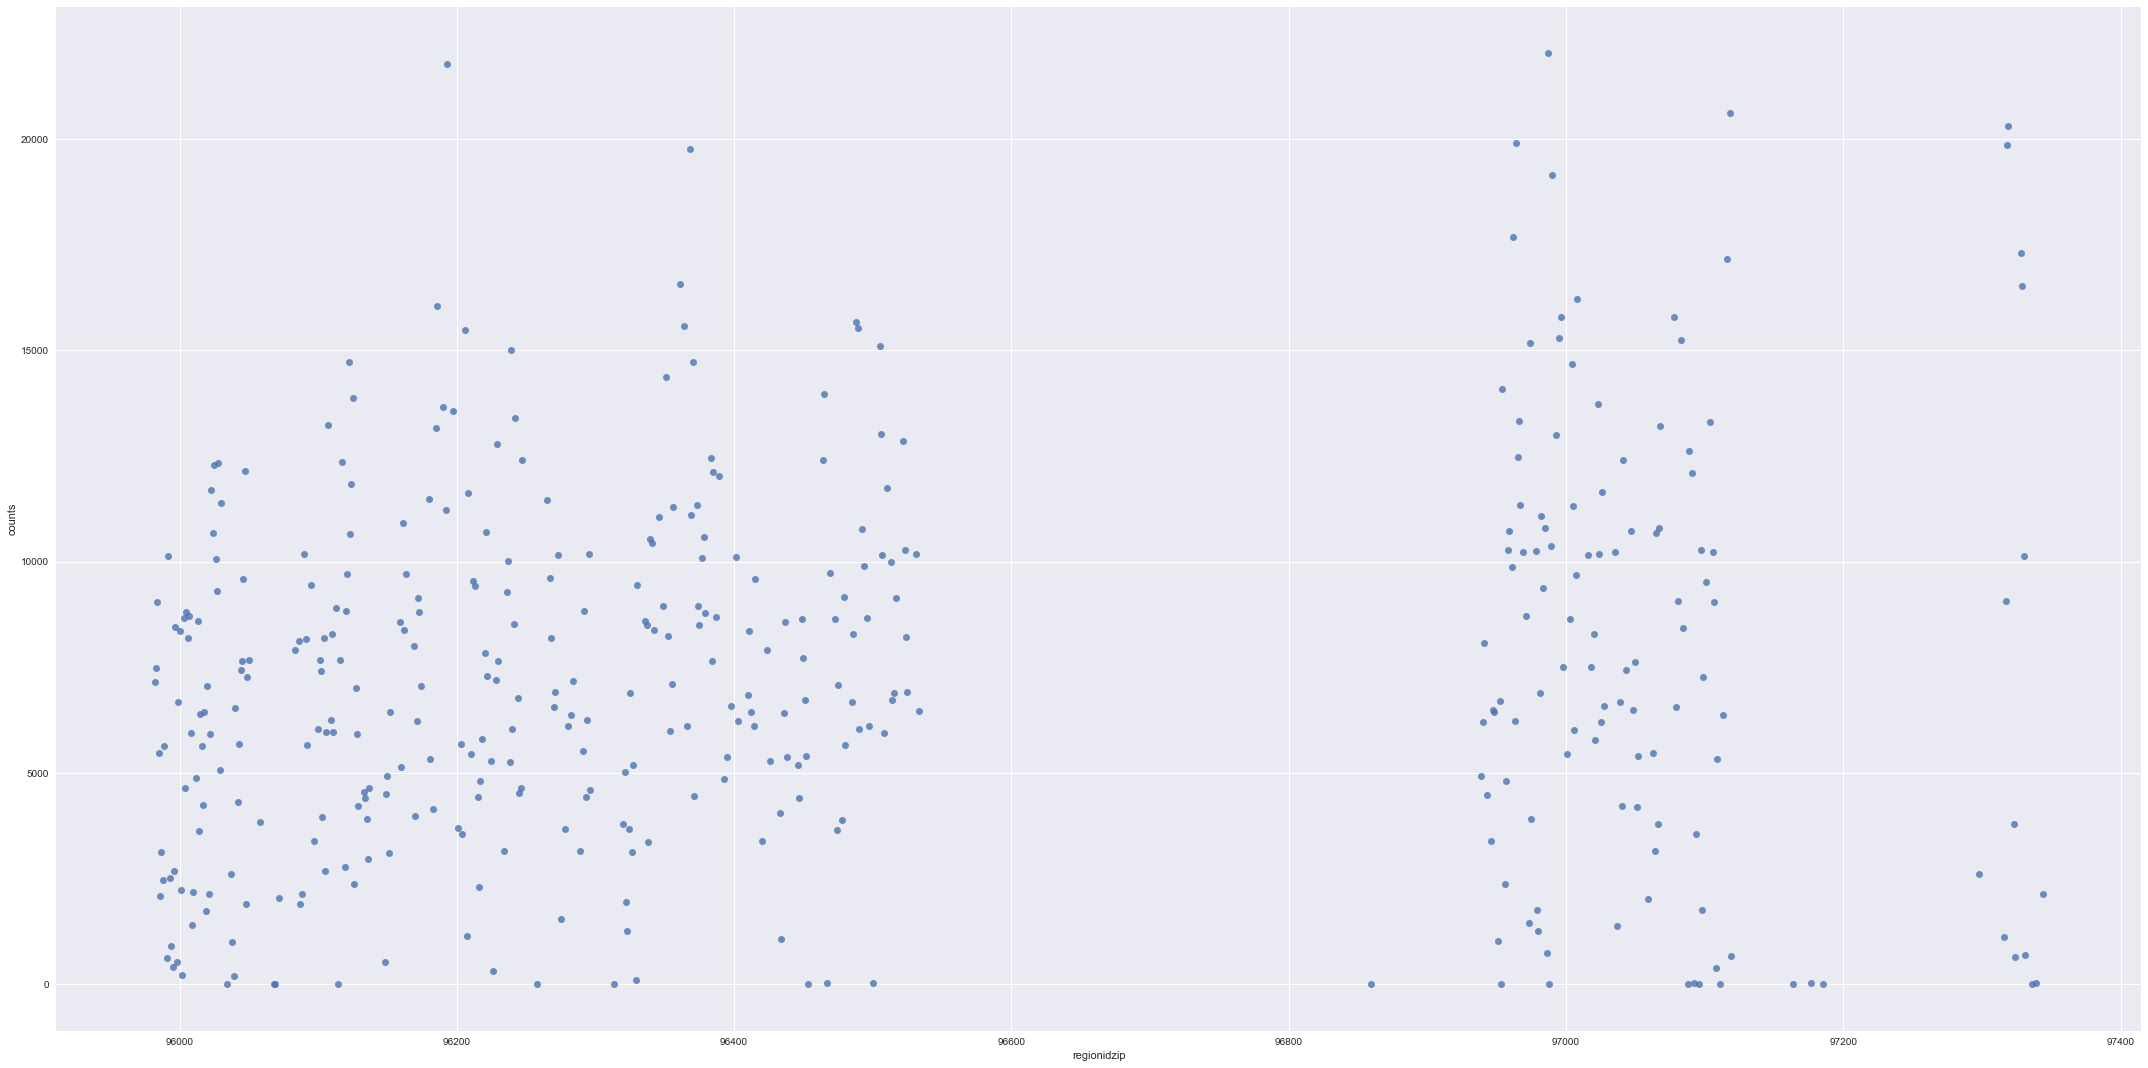

In [7]:
x = df.groupby(['regionidzip']).size().reset_index(name='counts')
y = x.loc[x['regionidzip'] < 350000]
sns.lmplot("regionidzip", "counts", data=y, size=15,aspect=2, fit_reg=False)

#### Bar chart showing distribution od houses with number of unitcnt.
we can see that most of the houses have only one unit.

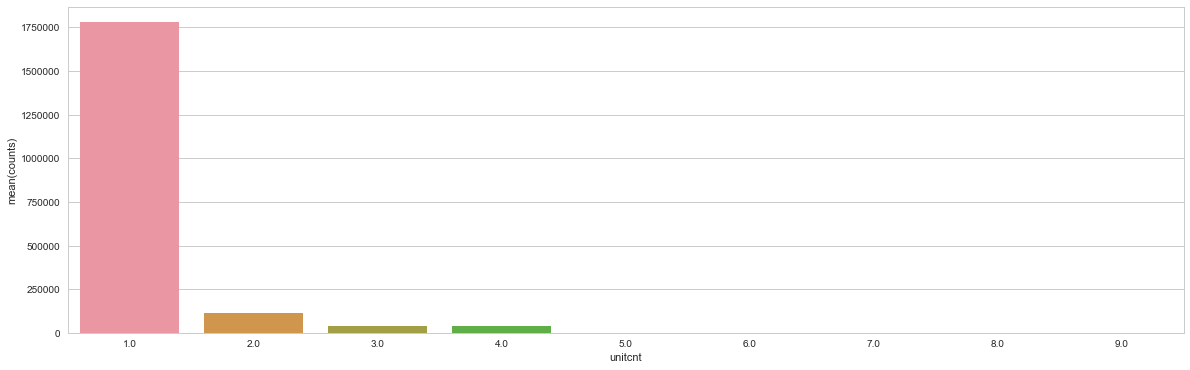

In [8]:
x = df.groupby(['unitcnt']).size().reset_index(name='counts')
y = x.loc[x['unitcnt'] < 10]
sns.plt.figure(figsize = (20,6))
sns.set_style("whitegrid")
ax = sns.barplot(x="unitcnt", y="counts", data=y)
plt.show()

#### Distribution of number of rooms in the given dataset
Here in the first graph we see, many house with zero number of rooms, which is clearly wrong. There seems to be some missing data. Therefore plotted the graph again with the missing data removed.

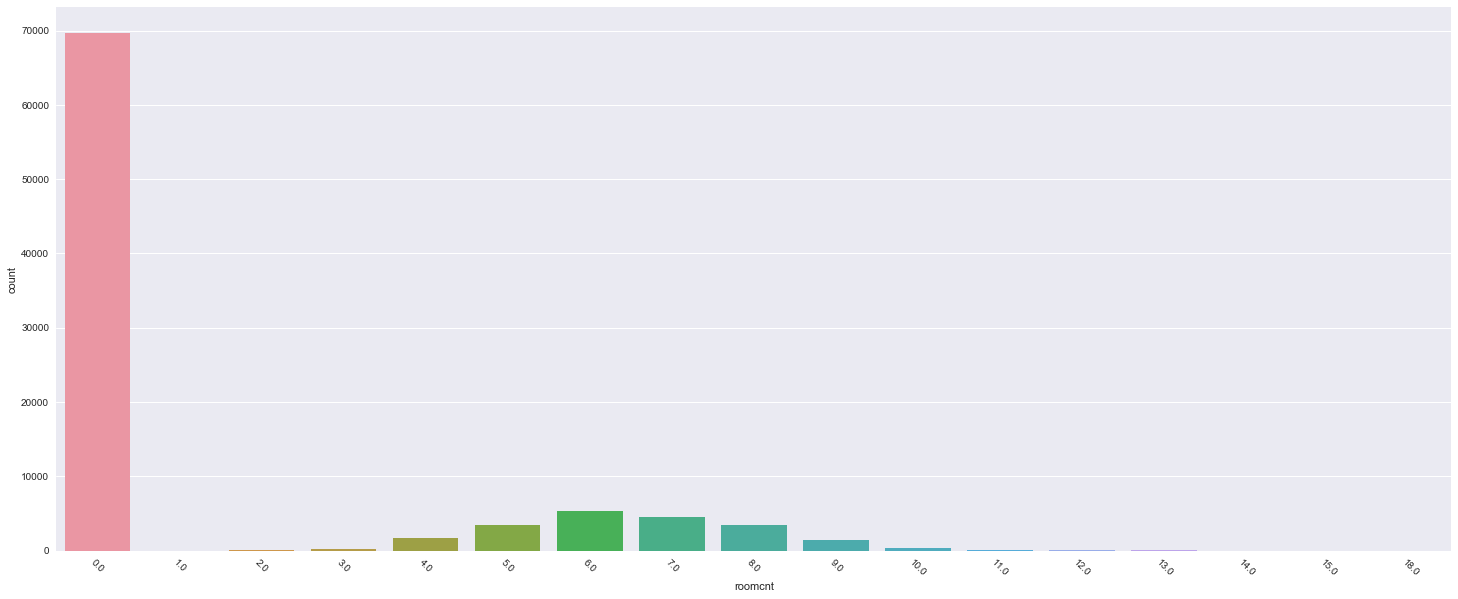

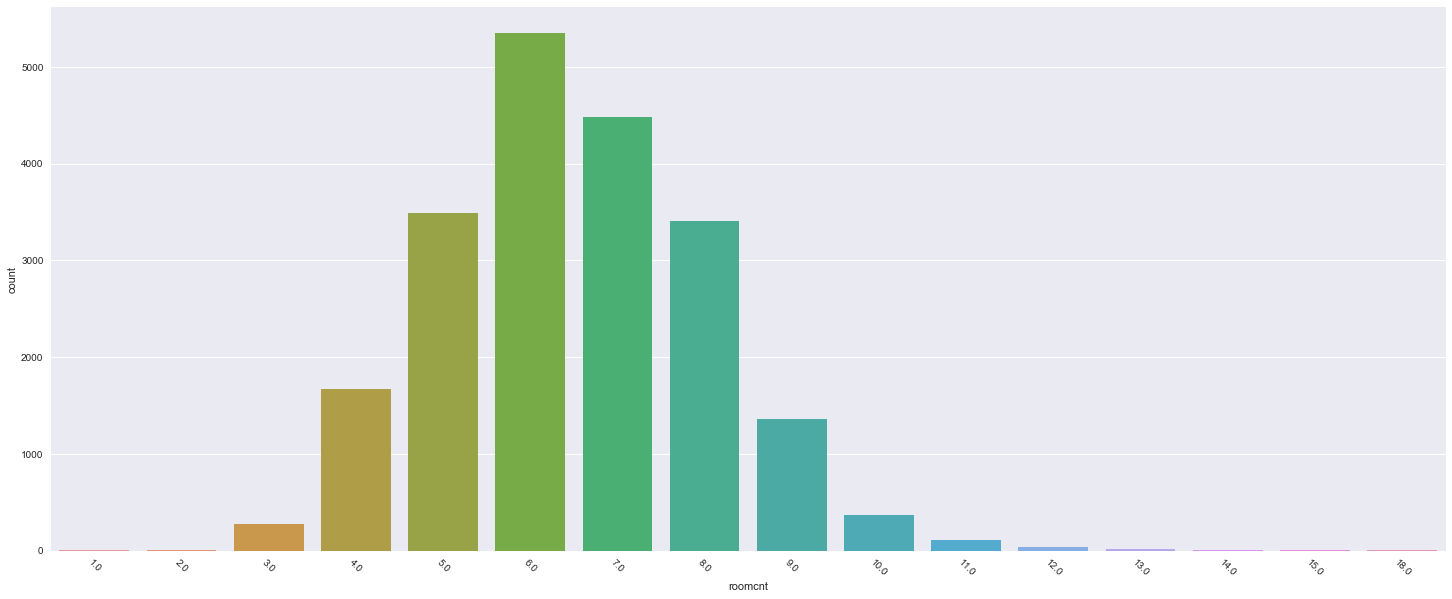

In [12]:
plt.figure(figsize=(25,10),facecolor='white')
sns.countplot(x='roomcnt', data=joined_data_copy)

# Rotate x-labels
plt.xticks(rotation=-45)
plt.show()
y = joined_data_copy.loc[joined_data_copy['roomcnt'] != 0]
plt.figure(figsize=(25,10),facecolor='white')
sns.countplot(x='roomcnt', data=y )

# Rotate x-labels
plt.xticks(rotation=-45)
plt.show()


#### BoxPlot between heatingorsytemtypeid and finishedsquarefeet12
The line in each box represent the mean of finishedsquarefeet12 for each heatingorsytemtypeid

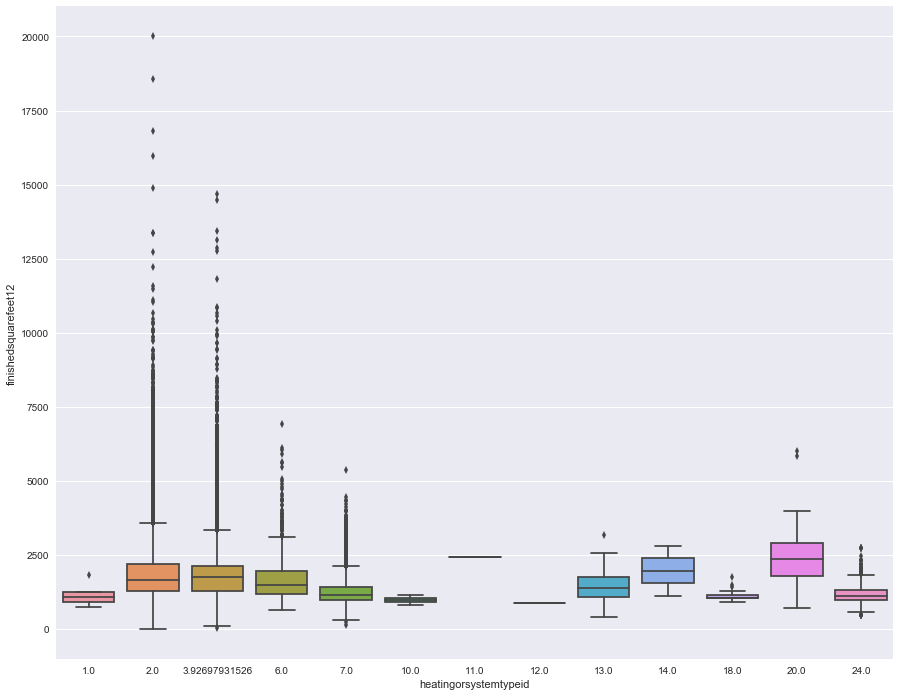

In [13]:
plt.figure(figsize=(15,12))
sns.boxplot(x='heatingorsystemtypeid',y='finishedsquarefeet12',data=joined_data_copy)
plt.show()

### Normalize function

In [8]:
def normalize(dataFrame):
    for col in dataFrame.keys():
        mean = np.mean(dataFrame[col])
        std = np.std(dataFrame[col])
        dataFrame[col] = (dataFrame[col]-mean)/std
    return dataFrame

In [9]:
features = ['heatingorsystemtypeid',
            'calculatedfinishedsquarefeet',
            'finishedsquarefeet12',
            'fullbathcnt',
            'taxamount',
            'structuretaxvaluedollarcnt',
            'landtaxvaluedollarcnt',
            'taxvaluedollarcnt',
            'transactiondate',
            'bedroomcnt',
            'threequarterbathnbr']

### Simple Linear regression model of multiple properties
A linear regression model is built with a couple of properties.
Here training and testing data is split with 3:1 ratio.
Mean square value and score is calculated accordingly.
Predictions are done for submission file and the file has been submitted to the challenge.

In [22]:
#target = target.apply(np.exp2) 
X = data_with_mean[features]
y = target['logerror']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=35)

lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)

predictions = lm.predict(X_test)
score = lm.score(X_test,y_test)
mse = (((predictions - y_test.values) ** 2).sum()) / len(predictions)
print("Sample Predictions")
print(predictions[0:5])
print("Actual Values")
print(list(y_test.head(5)))
print("Mean Square Error")
print(mse)
print("Score")
print(score)


predictions_oct16 = lm.predict(prediction_data_october16[features])
predictions_nov16 = lm.predict(prediction_data_november16[features])
predictions_dec16 = lm.predict(prediction_data_december16[features])
predictions_oct17 = lm.predict(prediction_data_october17[features])
predictions_nov17 = lm.predict(prediction_data_november17[features])
predictions_dec17 = lm.predict(prediction_data_december17[features])

linear_model_prediction_dataFrame1 = pd.DataFrame( { 'parcelid': parcelid['parcelid'], '201610': predictions_oct16, '201611': predictions_nov16, '201612' : predictions_dec16, '201710' :predictions_oct17, '201711' : predictions_nov17, '201712' : predictions_dec17  } )
linear_model_prediction_dataFrame1 = linear_model_prediction_dataFrame1.reindex_axis(['parcelid','201610','201611','201612','201710','201711','201712'], axis=1)
cols = ['parcelid','201610','201611','201612','201710','201711','201712']
linear_model_prediction_dataFrame1.to_csv('/Users/kiranmayi/Desktop/Sem1/DSF_519/Hw2/linear_model_prediction_dataFrame_few_final.csv',columns=cols,index=False)
print("------------------------")


Sample Predictions
[-0.01721734  0.03612123  0.02772046  0.01218885  0.0133932 ]
Actual Values
[-0.024299999999999999, 0.086199999999999999, 0.66369999999999996, 0.34570000000000001, 0.043099999999999999]
Mean Square Error
0.0245970986653
Score
0.00392526471584
------------------------


### Linear regression model after normalizing the data.

In [20]:
X = normalize(data_with_mean[features])
y = target['logerror']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.05, random_state=30)

lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)

predictions = lm.predict(X_test)
score = lm.score(X_test,y_test)
mse = (((predictions - y_test.values) ** 2).sum()) / len(predictions)

print("Sample Predictions")
print(predictions[0:5])
print("Actual Values")
print(list(y_test.head(5)))
print("Mean Square Error")
print(mse)
print("Score")
print(score)

predictions_oct16 = lm.predict(normalize(prediction_data_october16[features]))
predictions_nov16 = lm.predict(normalize(prediction_data_november16[features]))
predictions_dec16 = lm.predict(normalize(prediction_data_december16[features]))
predictions_oct17 = lm.predict(normalize(prediction_data_october17[features]))
predictions_nov17 = lm.predict(normalize(prediction_data_november17[features]))
predictions_dec17 = lm.predict(normalize(prediction_data_december17[features]))

linear_model_prediction_dataFrame1 = pd.DataFrame( { 'parcelid': parcelid['parcelid'], '201610': predictions_oct16, '201611': predictions_nov16, '201612' : predictions_dec16, '201710' :predictions_oct17, '201711' : predictions_nov17, '201712' : predictions_dec17  } )
linear_model_prediction_dataFrame1 = linear_model_prediction_dataFrame1.reindex_axis(['parcelid','201610','201611','201612','201710','201711','201712'], axis=1)
cols = ['parcelid','201610','201611','201612','201710','201711','201712']
linear_model_prediction_dataFrame1.to_csv('/Users/kiranmayi/Desktop/Sem1/DSF_519/Hw2/linear_model_prediction_dataFrame_few_norm_final.csv',columns=cols,index=False)
print("------------------------")


Sample Predictions
[ 0.00534831  0.01927293  0.01165895  0.0193623   0.02851556]
Actual Values
[-0.001, 0.013899999999999999, 0.0149, 0.0040000000000000001, -0.0080000000000000002]
Mean Square Error
0.0208306229688
Score
0.0100008680739
------------------------


### In the above Linear Model, I found that tax values taxamount, structuretaxvaluedollarcnt, landtaxvaluedollarcnt and taxvaluedollarcnt came out to be the most important values. I used these 4 features only and then incorporated the remaining feature. There was no significant increase the mean sqaure error. So, these 4 features are the most important features for the Linear Regression model 

### K-Nearest Neighbours model 
In this model, predictions are done for raw and normalized data separately
Predictions are done for the submission file and uploaded to kaggle.

In [16]:
X = data_with_mean[features]
y = target['logerror']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=35)

knn = KNeighborsRegressor(n_neighbors=750)
knn.fit(X_train, y_train)

predictions = knn.predict(X_test)
actual = y_test.values
mse = (((predictions - actual) ** 2).sum()) / len(predictions)
score = knn.score(X_test,y_test)

print("Sample Predictions")
print(predictions[0:5])
print("Actual Values")
print(actual[0:5])
print("Mean Square Error")
print(mse)
print("Score")
print(score)

predictions_oct16 = knn.predict(prediction_data_october16)
predictions_nov16 = knn.predict(prediction_data_november16)
predictions_dec16 = knn.predict(prediction_data_december16)
predictions_oct17 = knn.predict(prediction_data_october17)
predictions_nov17 = knn.predict(prediction_data_november17)
predictions_dec17 = knn.predict(prediction_data_december17)

knn_model_prediction_dataFrame = pd.DataFrame( { 'parcelid': parcelid['parcelid'], '201610': predictions_oct16, '201611': predictions_nov16, '201612' : predictions_dec16, '201710' :predictions_oct17, '201711' : predictions_nov17, '201712' : predictions_dec17  } )
knn_model_prediction_dataFrame = knn_model_prediction_dataFrame.reindex_axis(['parcelid','201610','201611','201612','201710','201711','201712'], axis=1)
cols = ['parcelid','201610','201611','201612','201710','201711','201712']
knn_model_prediction_dataFrame.to_csv('/Users/kiranmayi/Desktop/Sem1/DSF_519/Hw2/knn_model_prediction_dataFrame_few_final.csv',columns=cols,index=False)
print("---------------------")


Sample Predictions
[ 0.0117108   0.02826907  0.01182333  0.015908    0.0075536 ]
Actual Values
[-0.0243  0.0862  0.6637  0.3457  0.0431]
Mean Square Error
0.024674633953
Score
0.000785425249128
---------------------


In [17]:
X = normalize(data_with_mean[features])
y = target['logerror']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=35)

knn = KNeighborsRegressor(n_neighbors=350)
knn.fit(X_train, y_train)

predictions = knn.predict(X_test)
actual = y_test.values
mse = (((predictions - actual) ** 2).sum()) / len(predictions)
score = knn.score(X_test,y_test)

print("Sample Predictions")
print(predictions[0:5])
print("Actual Values")
print(actual[0:5])
print("Mean Square Error")
print(mse)
print("Score")
print(score)

predictions_oct16 = knn.predict(normalize(prediction_data_october16[features]))
predictions_nov16 = knn.predict(normalize(prediction_data_november16[features]))
predictions_dec16 = knn.predict(normalize(prediction_data_december16[features]))
predictions_oct17 = knn.predict(normalize(prediction_data_october17[features]))
predictions_nov17 = knn.predict(normalize(prediction_data_november17[features]))
predictions_dec17 = knn.predict(normalize(prediction_data_december17[features]))

knn_model_prediction_dataFrame = pd.DataFrame( { 'parcelid': parcelid['parcelid'], '201610': predictions_oct16, '201611': predictions_nov16, '201612' : predictions_dec16, '201710' :predictions_oct17, '201711' : predictions_nov17, '201712' : predictions_dec17  } )
knn_model_prediction_dataFrame = knn_model_prediction_dataFrame.reindex_axis(['parcelid','201610','201611','201612','201710','201711','201712'], axis=1)
cols = ['parcelid','201610','201611','201612','201710','201711','201712']
knn_model_prediction_dataFrame.to_csv('/Users/kiranmayi/Desktop/Sem1/DSF_519/Hw2/knn_model_prediction_dataFrame_few_norm_final.csv',columns=cols,index=False)
print("------------------------")

Sample Predictions
[-0.04692943  0.02919571  0.01323     0.00449657  0.01273257]
Actual Values
[-0.0243  0.0862  0.6637  0.3457  0.0431]
Mean Square Error
0.0246102560307
Score
0.003392449063
------------------------


### Random Forest Classifier model
The predictions are made for normalized data only.

In [10]:
X = normalize(data_with_mean_copy[features]).as_matrix()
y = target['logerror'].as_matrix()

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.10, random_state=30)

rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train, y_train)

predictions = rf.predict(X_test)
mse = (((predictions - y_test) ** 2).sum()) / len(predictions)
score = rf.score(X_test,y_test)

print("Sample Predictions")
print(predictions[0:5])
print("Actual Values")
print(y_test[0:5])
print("Mean Square Error")
print(mse)
print("Score")
print(score)


predictions_oct16 = rf.predict(normalize(prediction_data_october16[features]).as_matrix())
predictions_nov16 = rf.predict(normalize(prediction_data_november16[features]).as_matrix())
predictions_dec16 = rf.predict(normalize(prediction_data_december16[features]).as_matrix())
predictions_oct17 = rf.predict(normalize(prediction_data_october17[features]).as_matrix())
predictions_nov17 = rf.predict(normalize(prediction_data_november17[features]).as_matrix())
predictions_dec17 = rf.predict(normalize(prediction_data_december17[features]).as_matrix())

rf_model_prediction_dataFrame = pd.DataFrame( { 'parcelid': parcelid['parcelid'], '201610': predictions_oct16, '201611': predictions_nov16, '201612' : predictions_dec16, '201710' :predictions_oct17, '201711' : predictions_nov17, '201712' : predictions_dec17  } )
rf_model_prediction_dataFrame = rf_model_prediction_dataFrame.reindex_axis(['parcelid','201610','201611','201612','201710','201711','201712'], axis=1)
cols = ['parcelid','201610','201611','201612','201710','201711','201712']
rf_model_prediction_dataFrame.to_csv('/Users/kiranmayi/Desktop/Sem1/DSF_519/Hw2/rf_model_prediction_dataFrame_few_norm_final.csv',columns=cols,index=False)
print("-----------------------")

Sample Predictions
[ 0.0278035  0.020948   0.0061835  0.024279   0.0359125]
Actual Values
[-0.001   0.0139  0.0149  0.004  -0.008 ]
Mean Square Error
0.023863099947
Score
0.0133607036074
-----------------------
